**"Machine-Learning Mathematical Structures: Algebraic Geometry over the complex numbers."**

We will try to apply the ideas behind the article "Machine-Learning Mathematical Structures" by Yang-Hui He. For this, we will try to implement a Machine learning algorithm for each of the problem proposed in section 3. In this Jupyter Notebook we will focus on subsection 3.1 Warm-up.

The problem is: Consider a complex polynomial with coefficients which are Gaussian integers in the range ±10±10i, and check if there is a root with multiplicity bigger than one.

We start studying this problem by restricting us to quadratic polynomial, i.e. polynomial of degree two. In this case we have two options, there is a unique root or not.

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import keras.api._v2.keras as keras
import tensorflow as tf
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras import Sequential
from keras import utils
from keras.activations import sigmoid
from xgboost import XGBRegressor
le = LabelEncoder()

The data will be created synthetically using Numpy. We generate 2*10^7 random tuples (a[0], b[0], a[1], b[1], a[2], b[2]) of length six in our range, where each tuple will represent a polynomial of the form:

(a[0]+ib[0]) + (a[1]+ib[1])x + (a[2]+ib[2])x^2.

Since we want to study the multiplicity of roots of polynomials, we will not consider constant polynomials. Thus, we will drop those cases from our synthetic data.

In [3]:
Data = pd.DataFrame(np.random.randint(-10, 10, size = (20000000,6)), columns= ["a_0", "b_0", "a_1", "b_1", "a_2", "b_2"])
Data.drop(Data[(Data["a_1"] == 0) & (Data["a_2"] == 0) & (Data["b_1"] == 0) & (Data["b_2"] == 0)].index, axis = 0, inplace = True)

The polynomial is created using the Numpy.polynomial class, and we compute its roots using the "roots" method. We asign the value 0 to means having one unique root, and the value 1 to means having two different roots.

In [4]:
Data["MultRoots"] = Data.apply(lambda x : len(set(np.polynomial.Polynomial([complex(x["a_0"],x["b_0"]),complex(x["a_1"],x["b_1"]),complex(x["a_2"],x["b_2"])]).roots()))-1, axis = 1)
Data["MultRoots"].value_counts()

MultRoots
1    19950060
0       49816
Name: count, dtype: int64

Since having only one root puts a restriction on the coefficient of the polynomial, it was expected that the ammount of them was smaller.

For curiosity, we can check how correctly the Numpy "roots" method compute the roots. Remember that the discriminant of a polynomial tells us if there is a root with multiplicity greater than one.

In [5]:
Data["Discriminant"] = Data.apply(lambda x : 0 if complex(x["a_1"],x["b_1"])**2 - 4*complex(x["a_0"],x["b_0"])*complex(x["a_2"],x["b_2"]) else 1, axis = 1)
Data["Discriminant"].value_counts()

Discriminant
0    19999221
1         655
Name: count, dtype: int64

There is a big difference between the precision of both method. Given that the discriminant of a polynomial is harder to compute when the degree greater than two, we will still use the "roots" method to classify our data.

In [6]:
Data = Data.drop(["Discriminant"], axis = 1)

Since having an unique root is under-represented, we will shrink our database to obtain a balance between both categories.

In [7]:
Mult1 = Data[Data["MultRoots"] == 0]
Mult2 = Data[Data["MultRoots"] == 1].sample(n=len(Mult1))
DataCoeff = pd.concat([Mult1, Mult2], axis = 0, ignore_index = True)
DataCoeff = DataCoeff.sample(frac = 1, ignore_index = True)
print(DataCoeff)

       a_0  b_0  a_1  b_1  a_2  b_2  MultRoots
0        6    9    4   -2    1   -1          1
1       -4    3   -7    7    0    0          0
2       -1    4    4    6   -6    4          1
3      -10   -4   -9   -4   -9   -3          1
4        3   -2    4    2   -4   -1          1
...    ...  ...  ...  ...  ...  ...        ...
99627    2    6  -10    8    0    0          0
99628   -2   -2   -4    0    0    0          0
99629    8    9    0    2    0    5          1
99630    0    2   -9   -9    0    0          0
99631   -1    1    8    2    0    0          0

[99632 rows x 7 columns]


We split our data in Train and Validation set using a 0.8/0.2 ratio.

In [8]:
Data_Roots = DataCoeff.pop("MultRoots")
train_X, val_X, train_y, val_y = train_test_split(DataCoeff, Data_Roots, train_size = 0.8)

We define our Neural Network. Each hyperparameter is tuned by trial and error. We use Early Stopping to avoid overfitting.

2023-12-11 10:54:46.826529: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-11 10:54:46.826742: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-11 10:54:46.826750: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-11 10:54:46.826962: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-11 10:54:46.827329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-12-11 10:54:47.909386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Best Validation Loss: 0.6901
Best Validation Accuracy: 0.5786


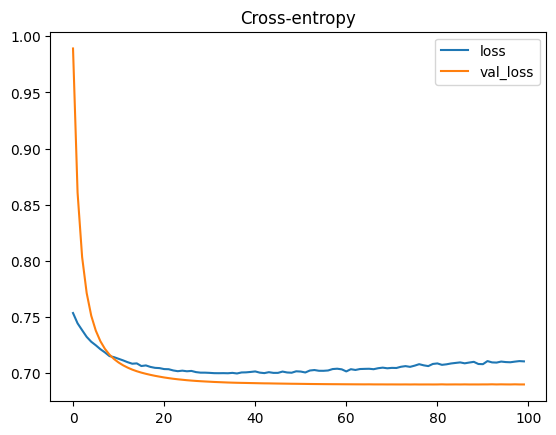

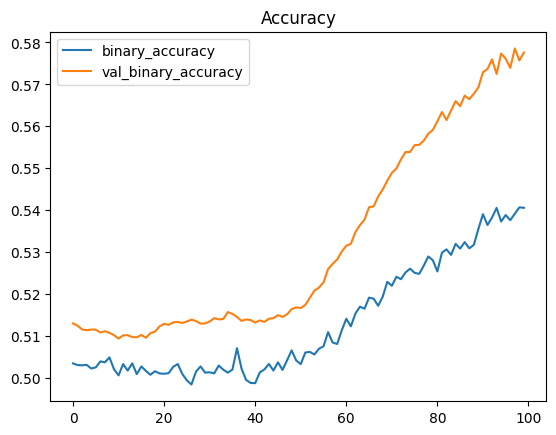

In [9]:
model = keras.Sequential([
    BatchNormalization(input_shape=[6]),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer= tf.keras.optimizers.legacy.Adam(learning_rate = 0.0001), 
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)
early_stopping = keras.callbacks.EarlyStopping(
    patience=50,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=8000,  
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

We plot a Confusion Matrix to see more explicitely how the model is predicting each value. The closer to a Diagonal matrix, the better.

623/623 [==============================] - 1s 2ms/step


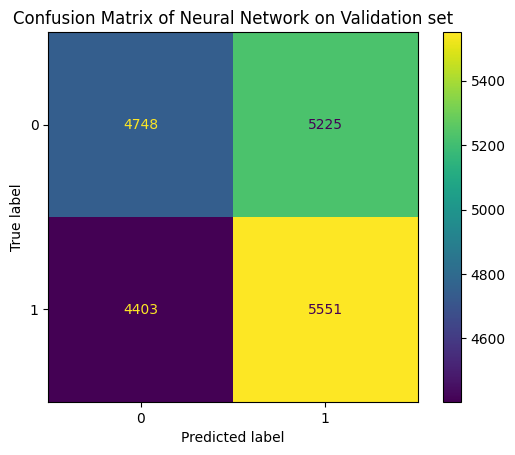

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(val_y, (model.predict(val_X) > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Confusion Matrix of Neural Network on Validation set")
plt.show()

We can see that our Neural Network have a low accuracy. We will try with a Random Forest. Hyperparameters are tuned by trial and error.

In [11]:
RF_Model = RandomForestClassifier(max_depth=8, min_samples_leaf=1, min_samples_split=3, n_estimators=10, verbose=0)

In [12]:
RF_Model.fit(train_X, train_y)

RandomForestClassifier(max_depth=8, min_samples_split=3, n_estimators=10)

In [13]:
print(f'Train Accuracy: {RF_Model.score(train_X, train_y):.5f}')
print(f'Validation Accuracy: {RF_Model.score(val_X, val_y):.5f}')

Train Accuracy: 0.99956
Validation Accuracy: 0.99955


We compute the Confusion Matrix to analyze the prediction done by the Forest model.

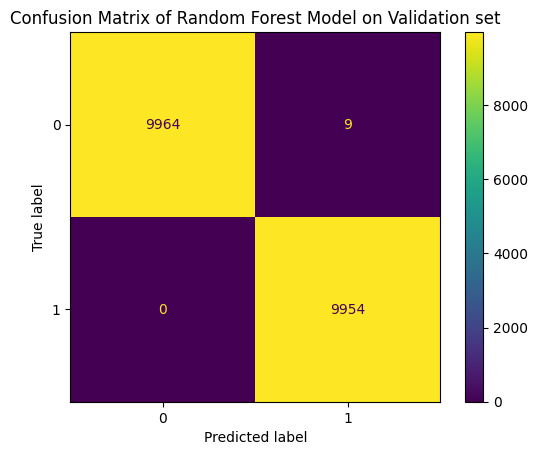

In [14]:
cm = confusion_matrix(val_y, (RF_Model.predict(val_X) > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Confusion Matrix of Random Forest Model on Validation set")
plt.show()

Finally, we test our model in a new created Dataset, which will not be balanced.

In [15]:
Data_test = pd.DataFrame(np.random.randint(-10, 10, size = (1000000,6)), columns= ["a_0", "b_0", "a_1", "b_1", "a_2", "b_2"])
Data_test.drop(Data_test[(Data_test["a_1"] == 0) & (Data_test["a_2"] == 0) & (Data_test["b_1"] == 0) & (Data_test["b_2"] == 0)].index, axis = 0, inplace = True)
Data_test["MultRoots"] = Data_test.apply(lambda x : len(set(np.polynomial.Polynomial([complex(x["a_0"],x["b_0"]),complex(x["a_1"],x["b_1"]),complex(x["a_2"],x["b_2"])]).roots()))-1, axis = 1)
Data_test_roots = Data_test.pop("MultRoots")


Since the forest model have great results, we will test it first.

Test Accuracy: 0.9999


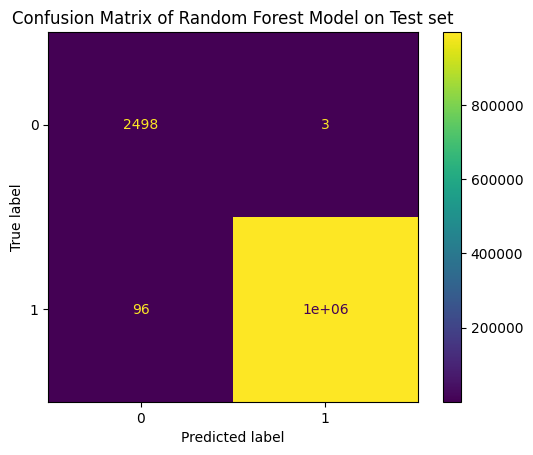

In [18]:
print(f'Test Accuracy: {RF_Model.score(Data_test, Data_test_roots):.4f}')
cm = confusion_matrix(Data_test_roots, (RF_Model.predict(Data_test) > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Confusion Matrix of Random Forest Model on Test set")
plt.show()

The Neural Network model still have poor results as we can see.

Test Accuracy: 0.5786
31250/31250 [==============================] - 56s 2ms/step


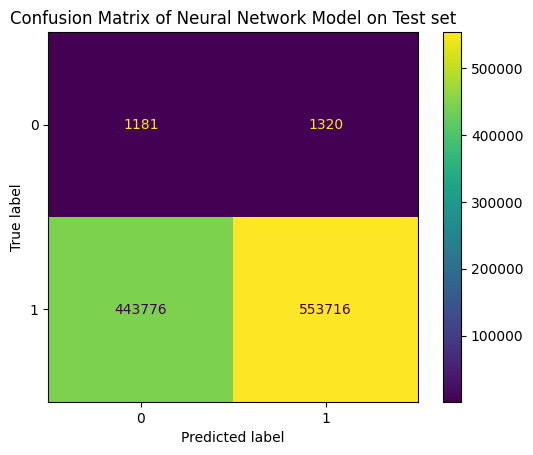

In [17]:
print(("Test Accuracy: {:0.4f}")\
      .format( history_df['val_binary_accuracy'].max()))
cm = confusion_matrix(Data_test_roots, (model.predict(Data_test) > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title("Confusion Matrix of Neural Network Model on Test set")
plt.show()